<a href="https://colab.research.google.com/github/VielF/ColabProjects/blob/main/Exemplo_de_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Universidade do Vale do Itajaí<br>
Escola do Mar, Ciência e Tecnologia<br>
Engenharia de Computação - Processamento Digital de Sinais: Imagens

# Exercício de Redes Neurais Convolucionais

### Tutoriais da OpenCV

- https://docs.opencv.org/master/d9/df8/tutorial_root.html
- https://www.geeksforgeeks.org/opencv-python-tutorial/
- https://www.tensorflow.org/tutorials?hl=pt-br
- https://keras.io/examples/ 

## Redes Convolucionais

Nestes exemplos são usadas arquiteturas de redes convolucionais para reconhecimento de imagens. Além de treinar uma rede a partir do zero, é apresentado técnicas de ajuste fino (*fine tuning*) a partir de uma rede pré-treinada (*transfer learning*).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import sys
print('Python version:', sys.version.split(' ')[0])

import tensorflow as tf
print('TensorFlow version:', tf.__version__)

# Find out NVIDIA GPU model (randomly assigned by Colab)
# Deep learning performance: K80 < P4 < T4 < P100
# https://ai-benchmark.com/ranking_deeplearning.html
gpu = !nvidia-smi -L
gpu = gpu[0].split(' (')[0]
if 'failed' in gpu:
  print('GPU: None')
else:
  print(gpu, '\n')
  # GPU information
  !nvidia-smi

Python version: 3.7.10
TensorFlow version: 2.4.1
GPU 0: Tesla T4 

Mon Mar 29 18:32:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                     

In [ ]:
def plots(history):
    plt.figure(figsize=(14,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], '.-', label='Train loss')
    if 'val_loss' in history.history.keys():
        plt.plot(history.history['val_loss'], '.-', label='Val loss')
    plt.xlabel('Epochs');
    plt.legend();
    plt.grid();
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], '.-', label='Train accuracy')
    plt.xlabel('Epochs');
    if 'val_accuracy' in history.history.keys():
        plt.plot(history.history['val_accuracy'], '.-', label='Val accuracy')
        plt.legend();
        plt.grid();

# 1. Treinando a partir do zero

## MNIST

1. Neste exemplo, é carregado conjunto MNIST e separedo as últimas 5000 imagens como conjunto de validação. Não é realizado qualquer pré-processamento nas imagens (como escalonamento); isto será feito [internamente no modelo](https://keras.io/guides/preprocessing_layers/#preprocessing-data-before-the-model-or-inside-the-model) depois.

In [ ]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#x_train = x_train / 255
#x_test = x_test / 255
#x_train = x_train.astype(np.uint8)
#x_test = x_test.astype(np.uint8)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [ ]:
x_val = x_train[55000:]
y_val = y_train[55000:]
print(x_train.dtype)
print("Train shapes: ", x_train.shape)
print(x_val.dtype)
print("Val shapes: ",x_val.shape)
print(x_test.dtype)
print("Test shapes: ",x_test.shape)
print(x_test.shape[0])
#num_classes = 10

#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)

uint8
Train shapes:  (60000, 28, 28)
uint8
Val shapes:  (5000, 28, 28)
uint8
Test shapes:  (10000, 28, 28)
10000


2. Usando o Keras, é construido uma rede neural com pelo menos uma camada convolucional (`tf.keras.layers.Conv2D`). O exemplo está organizado com o código contendo uma função de criação do modelo. São utilizadas camadas de *reshape*.

#### Dicas
- Funções úteis: `tf.keras.layers.experimental.preprocessing.Rescaling`, `tf.keras.layers.Reshape`
- Camadas convolucionais 2D exigem que a entrada seja um tensor 3D, sendo o último eixo correspondente ao número de canais (no caso, apenas 1, para uma imagem em tons de cinza).

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

dim_x, dim_y, dim_z = 28,28,1
size_train = x_train[0]

def make_model():
    model = keras.Sequential(
      [
       keras.Input(shape=(28,28)),
       layers.experimental.preprocessing.Rescaling(scale=1/255),
       layers.Reshape((dim_x, dim_y, dim_z)),
       layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
       layers.MaxPooling2D(pool_size=(2, 2)),
       layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
       layers.MaxPooling2D(pool_size=(2, 2)),
       layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
       layers.MaxPooling2D(pool_size=(2, 2)),
       layers.Dropout(0.3),
       layers.Flatten(),
       layers.Dense(128, activation='relu'), #using 128 to get the same number of neurons of last Conv2D Layer
       layers.Dense(10, activation='softmax'),
      ]
      )
    return model
make_model().summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_4 (Rescaling)      (None, 28, 28)            0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 3, 128)        

3. Agora é desenvolvida (i.e., aprimorando a arquitetura) e é treinada uma rede (a partir do zero), tentando conseguir uma acurácia de validação de pelo menos 99.2%. (Apenas com camadas densas é difícil conseguir uma acurácia muito superior a 98%.) Em seguida, é caluculado a acurácia no conjunto de teste.


In [ ]:
#tf.random.set_seed(0)
model = make_model()
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train[:55000], y_train[:55000], epochs=20, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5574 - accuracy: 0.8161 - val_loss: 0.0861 - val_accuracy: 0.9756
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1078 - accuracy: 0.9680 - val_loss: 0.0441 - val_accuracy: 0.9884
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0742 - accuracy: 0.9773 - val_loss: 0.0399 - val_accuracy: 0.9902
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0592 - accuracy: 0.9820 - val_loss: 0.0478 - val_accuracy: 0.9854
Epoch 5/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0465 - accuracy: 0.9856 - val_loss: 0.0456 - val_accuracy: 0.9874
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0406 - accuracy: 0.9879 - val_loss: 0.0364 - val_accuracy: 0.9902
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.0348 - accuracy: 0.9889 - val_loss: 0.0417 - val_accuracy:

4. (OPCIONAL) Por que o uso de Dropout faz com que o desempenho de treinamento comece bastante inferior ao de validação?
Resposta: 

#### Dicas
- Parta da arquitetura deste [tutorial](https://keras.io/examples/vision/mnist_convnet) (com os devidos ajustes feitos no item anterior) e adicione uma camada densa com um número suficiente de unidades. Lembre-se de (ao contrário do tutorial) trazer para dentro do modelo qualquer pré-processamento necessário.
- Visualize os gráficos do treinamento usando a função `plots` fornecida (ou a ferramenta TensorBoard).
- Ao usar camadas convolucionais com GPU, a execução paralelizada torna impossível garantir a reproducibilidade, portanto, não perca tempo com isso.

## (EXERCÍCIO OPCIONAL) Fashion-MNIST

5. (OPCIONAL) Repita para o conjunto [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist), o qual também está [disponível no Keras](https://keras.io/api/datasets/fashion_mnist). Nesse caso, é suficiente aproveitar a mesma arquitetura do modelo e apenas (se necessário) alterar a taxa de aprendizado e o número de épocas. Sem muito esforço é possível conseguir uma acurácia de validação de 92% (em comparação com 87% para uma rede densa). Se desejar, visualize algumas imagens do conjunto de treinamento e algumas predições erradas no conjunto de teste.

## CIFAR-10

Agora, vamos utilizar um conjunto um pouco mais complexo, o [CIFAR-10](https://en.wikipedia.org/wiki/CIFAR-10), também [disponível no Keras](https://keras.io/datasets/).


In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train.dtype:', x_train.dtype)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

x_train.dtype: uint8
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


Observe que o `shape` do array `y` precisa ser corrigido:
- Para usar a perda `sparse_categorical_crossentropy`, `y` precisa ser um tensor 1D com valores em `[0, 1, ..., n_classes-1]`
- Para usar a perda `categorical_crossentropy`, `y` precisa ser um tensor 2D com *shape* `(n_samples, n_classes)` e codificação *one-hot*


In [ ]:
# Make sure y is a 1D tensor, so we can use sparse_categorical_crossentropy loss
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# Validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=5000, shuffle=False)
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(45000, 32, 32, 3) (45000,)
(5000, 32, 32, 3) (5000,)
(10000, 32, 32, 3) (10000,)


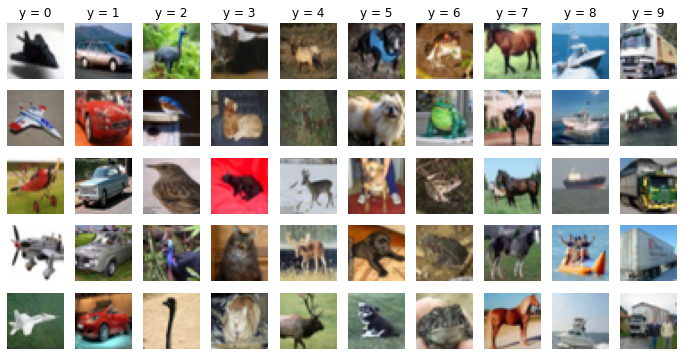

In [ ]:
plt.figure(figsize=(12,6))
for i in range(5):
    for c in range(10):
        plt.subplot(5, 10, 10*i+c+1)
        img = x_train[y_train == c][i]
        plt.imshow(img)
        if i == 0:
            plt.title('y = {}'.format(c))
        plt.axis('off')

In [ ]:
num_classes = 10 #CIFAR-10

#ajustando y para categorical_crossentropy
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

dim_x, dim_y, dim_z = 32, 32, 3

def make_model_CIFAR():
  model = keras.Sequential(
      [
       keras.Input(shape=(32, 32,3)),
       layers.experimental.preprocessing.Rescaling(scale=1/255),
       layers.Reshape((dim_x, dim_y, dim_z)),
       layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
       layers.MaxPooling2D(pool_size=(2, 2)),
       layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
       layers.MaxPooling2D(pool_size=(2, 2)),
       layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
       layers.MaxPooling2D(pool_size=(2, 2)),
       layers.Dropout(0.3),
       layers.Flatten(),
       layers.Dense(128, activation='relu'), #using 128 to get the same number of neurons of last Conv2D Layer
       layers.Dense(10, activation='softmax'),
      ]
  )
  return model
make_model_CIFAR().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 32, 32, 3)         0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         7

6. Aqui é apenas convertido a mesma arquitetura utilizada no MNIST para o formato das imagens do CIFAR-10 e treinado o modelo. Note que agora não é mais necessário usar uma camada `Reshape`. É também necessário se certificar de escolher um batch size e taxa de aprendizado apropriadas. Observe que é difícil obter uma acurácia de validação superior a 73%.

7. (OPCIONAL) Por que você acha que isso acontece? Explique.

In [ ]:
model = make_model_CIFAR()
model.compile(optimizer=keras.optimizers.Adam(0.001),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=20, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/20
704/704 [==============================] - 36s 5ms/step - loss: 1.8654 - accuracy: 0.3000 - val_loss: 1.3294 - val_accuracy: 0.5268
Epoch 2/20
704/704 [==============================] - 3s 4ms/step - loss: 1.3383 - accuracy: 0.5198 - val_loss: 1.1712 - val_accuracy: 0.5830
Epoch 3/20
704/704 [==============================] - 3s 4ms/step - loss: 1.1919 - accuracy: 0.5772 - val_loss: 1.1166 - val_accuracy: 0.6024
Epoch 4/20
704/704 [==============================] - 3s 4ms/step - loss: 1.0829 - accuracy: 0.6173 - val_loss: 0.9922 - val_accuracy: 0.6578
Epoch 5/20
704/704 [==============================] - 3s 4ms/step - loss: 0.9987 - accuracy: 0.6458 - val_loss: 0.9132 - val_accuracy: 0.6934
Epoch 6/20
704/704 [==============================] - 3s 4ms/step - loss: 0.9545 - accuracy: 0.6667 - val_loss: 0.9054 - val_accuracy: 0.6792
Epoch 7/20
704/704 [==============================] - 3s 4ms/step - loss: 0.8930 - accuracy: 0.6838 - val_loss: 0.8907 - val_accuracy: 0.6888
Epoch

### Data augmentation
Para melhorar o desempenho, utilizaremos a técnica de aumento de dados (*data augmentation*). Há duas formas principais de utilizar esta técnica no Keras:
- Usando a função [`tf.keras.preprocessing.image.ImageDataGenerator`](https://keras.io/api/preprocessing/image/#imagedatagenerator-class), a qual opcionalmente permite aplicar transformações aleatórias. Esta é a abordagem mais tradicional.
- Usando camadas de *data augmentation* como parte do modelo, as quais aplicam transformações aleatórias *somente* durante o treinamento (ficando inativas fora do treinamento). Esta é uma abordagem mais recente e ainda experimental. A principal vantagem é tornar as operações mais rápidas pelo uso da GPU, conforme explicado [neste tutorial](https://keras.io/guides/preprocessing_layers/#preprocessing-data-before-the-model-or-inside-the-model) e também [neste](https://keras.io/examples/vision/image_classification_from_scratch/#two-options-to-preprocess-the-data).

Para acelerar o treinamento usaremos aqui a segunda abordagem. Um exemplo é mostrado abaixo; você pode adicionar outras transformações se desejar.



In [ ]:
from tensorflow.keras import Sequential


In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomTranslation
data_augmentation = Sequential(
    [
     RandomTranslation(height_factor=0.1, width_factor=0.1),
     RandomFlip(mode='horizontal'),
    ],
    name='data_augmentation',
)

In [ ]:
def make_model_CIFAR():
  model = Sequential(
      [
       keras.Input(shape=(32, 32,3)),
       data_augmentation,
       layers.experimental.preprocessing.Rescaling(scale=1/255),
       #layers.Reshape((dim_x, dim_y, dim_z)),
       layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
       layers.MaxPooling2D(pool_size=(2, 2)),
       layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
       layers.MaxPooling2D(pool_size=(2, 2)),
       layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
       layers.MaxPooling2D(pool_size=(2, 2)),
       layers.Dropout(0.5),
       layers.Flatten(),
       layers.Dense(128, activation='relu'), #using 128 to get the same number of neurons of last Conv2D Layer
       layers.Dense(10, activation='softmax'),
      ]
  )
  return model
make_model().summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 32, 32, 3)         0         
_________________________________________________________________
rescaling_11 (Rescaling)     (None, 32, 32, 3)         0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 6, 6, 64)        

**Obs:** Aparentemente há um bug ainda não resolvido nas camadas `RandomTranslation` e `RandomRotation`, conforme descrito [aqui](https://stackoverflow.com/questions/62339559/black-pixels-outside-the-border-when-using-keras-layers-experimental-preprocessi) e visualizado por exemplo [aqui](https://keras.io/examples/vision/image_classification_from_scratch/#using-image-data-augmentation), [aqui](https://keras.io/guides/transfer_learning/#using-random-data-augmentation) e nas imagens abaixo. (Não deveria haver bordas pretas nas imagens transformadas.) Felizmente esse defeito não afeta o desempenho de forma significativa.

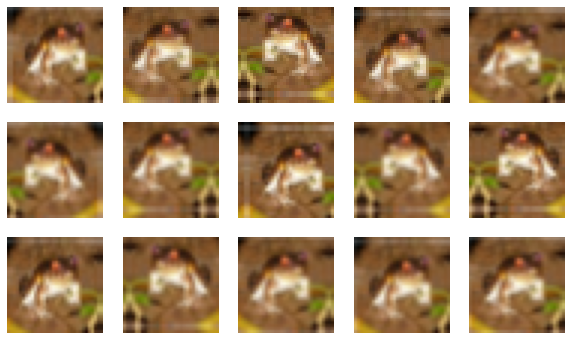

In [ ]:
plt.figure(figsize=(10, 6))
i = 0
for j in range(15):
  img = data_augmentation(x_train[[i]])[0].numpy()
  plt.subplot(3, 5, j+1)
  plt.imshow(img.astype('uint8'))
  plt.axis('off')

8. Aqui, o modelo foi treinaod até obter pelo menos 80% de acurácia de validação. Note que é preciso um número elevado de épocas (100 ou mais), o que deve levar vários minutos.

#### Dicas
- Certifique-se de usar uma taxa de aprendizado apropriada ao longo de todo o treinamento. Por exemplo:
 - Treine por N épocas com taxa constante, observe os resultados, depois continue o treinamento por mais N épocas, etc. Se em algum ponto o desempenho não estiver melhorando, reduza manualmente a taxa de aprendizado;
 - Utilize uma *callback* de decaimento, como [`ReduceLROnPlateau`](https://keras.io/api/callbacks/reduce_lr_on_plateau/) ou a genérica [`LearningRateScheduler`](https://keras.io/api/callbacks/learning_rate_scheduler/); ou
 - Utilize um valor pequeno constante e tenha bastante paciência.

-  Fique à vontade para aprimorar o modelo se desejar. Para facilitar, você pode se basear em quaisquer outras referências ou tutoriais disponíveis, como por exemplo: [Tutorial 1](https://www.learnopencv.com/image-classification-using-convolutional-neural-networks-in-keras) ou [Tutorial 2](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification). Note que alguns tutoriais estão desatualizados; por exemplo, a função `fit_generator` tornou-se obsoleta, tendo sido incorporada à função `fit`. No entanto, esteja ciente de que não é necessário um modelo muito complexo para obter a acurácia desejada.

In [ ]:
model = make_model_CIFAR()
model.compile(optimizer=keras.optimizers.Adam(0.002),
              loss=keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs=25, batch_size=32, validation_data=(x_val, y_val))

Epoch 1/25
1407/1407 [==============================] - 7s 4ms/step - loss: 1.8915 - accuracy: 0.2881 - val_loss: 1.4335 - val_accuracy: 0.4736
Epoch 2/25
1407/1407 [==============================] - 6s 4ms/step - loss: 1.4745 - accuracy: 0.4599 - val_loss: 1.2403 - val_accuracy: 0.5508
Epoch 3/25
1407/1407 [==============================] - 6s 4ms/step - loss: 1.3859 - accuracy: 0.4954 - val_loss: 1.1542 - val_accuracy: 0.5878
Epoch 4/25
1407/1407 [==============================] - 6s 4ms/step - loss: 1.3380 - accuracy: 0.5216 - val_loss: 1.0798 - val_accuracy: 0.6306
Epoch 5/25
1407/1407 [==============================] - 6s 4ms/step - loss: 1.2606 - accuracy: 0.5479 - val_loss: 1.0697 - val_accuracy: 0.6148
Epoch 6/25
1407/1407 [==============================] - 6s 4ms/step - loss: 1.2248 - accuracy: 0.5597 - val_loss: 1.0348 - val_accuracy: 0.6354
Epoch 7/25
1407/1407 [==============================] - 6s 4ms/step - loss: 1.2147 - accuracy: 0.5668 - val_loss: 0.9897 - val_accuracy:

# 2. Usando uma rede pré-treinada (*transfer learning & fine-tuning*)

1. Partindo de alguma [rede pré-treinada](https://keras.io/applications/)  fornecida pelo Keras, é treinado uma rede convolucional para [classificação entre gatos e cachorros](https://www.kaggle.com/c/dogs-vs-cats). Para isto, foi siguido este [tutorial](https://keras.io/guides/transfer_learning) (escrito pelo próprio criador do Keras). Antes de seguir o tutorial, provavelmente será útil conhecer os conceitos básicos da [API funcional](https://keras.io/guides/functional_api/) do Keras.
1. (OPCIONAL) Experimente outros modelos pré-treinados e/ou outros conjuntos de dados. O [tutorial específico sobre EfficientNet](https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/) pode ser interessante.
1. (OPCIONAL) Se desejar, você pode aplicar um modelo pré-treinado para classificaro CIFAR-10. No entanto, para obter um desempenho satisfatório nesse caso, será necessário previamente alargar (*resize*) as imagens para um tamanho mais próximo do das imagens da ImageNet (`224 x 224`), para que os filtros treinados possam ser relevantes. Por outro lado, um alargamento excessivo pode introduzir distorções (*artifacts*) que podem prejudicar o desempenho.

#### Dicas
- Antes de aplicar um modelo pré-treinado, geralmente é necessário realizar algum pré-processamento exigido pelo modelo. Ao invés de realizar esse pré-processamento manualmente, como feito no tutorial, é suficiente e mais conveniente utilizar a função `preprocess_input`, disponível no módulo de cada modelo pré-treinado. Por exemplo:
```python
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
base_model = ResNet50V2(include_top=False, input_shape=(150, 150, 3), pooling='avg')
base_model.trainable = False
(...)
x = preprocess_input(x)
x = base_model(x, training=False)
(...)
```
- Para inspecionar as camadas do modelo pré-treinado, utilize `base_model.summary()`
- Antes de utilizar um modelo com a opção `include_top=False`, é útil inspecionar o modelo completo (com a opção `include_top=True`), uma vez que será necessário recriar (e retreinar) as camadas finais removidas.
- Outras referências interessantes (embora mais antigas): [Tutorial 3](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/) e [Tutorial 4](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/)

### Primeiro Dataset

In [ ]:
#https://keras.io/examples/vision/image_classification_from_scratch/

!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
!unzip -q kagglecatsanddogs_3367a.zip
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   134M      0  0:00:05  0:00:05 --:--:--  147M
 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


In [ ]:
!ls PetImages

Cat  Dog


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [ ]:
#criando o dataset
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


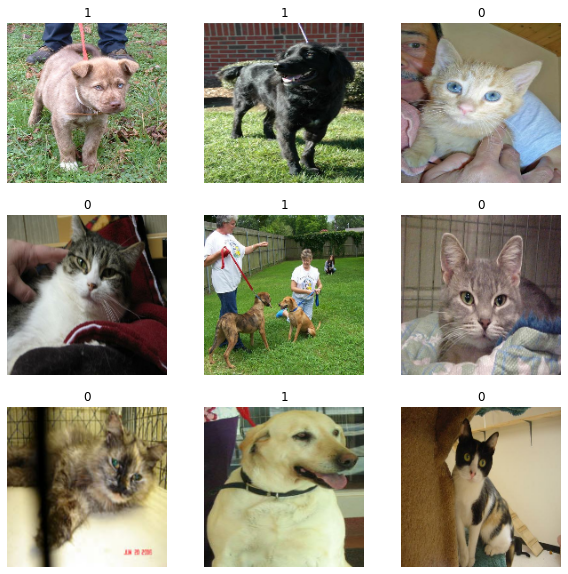

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


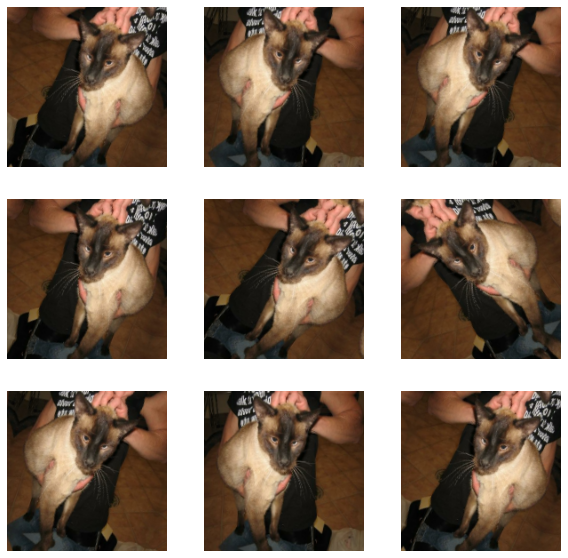

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

#### Segundo dataset

In [ ]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteWTFF1M/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


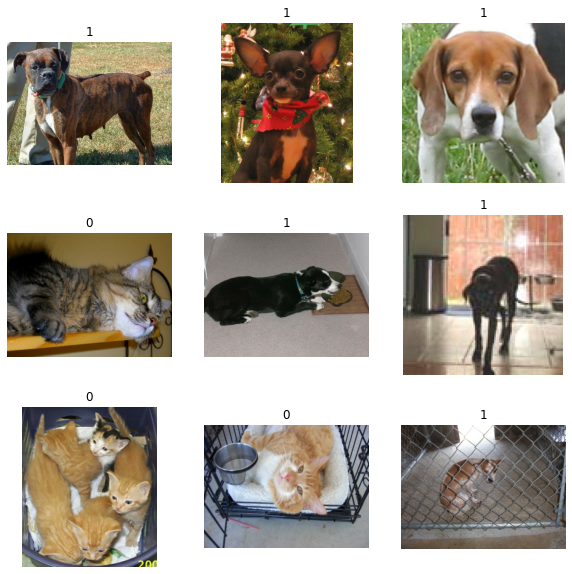

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [ ]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

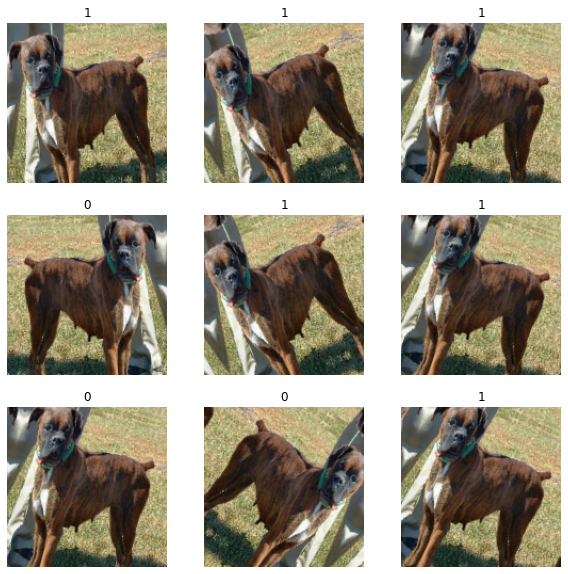

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

### Modelo

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

base_model = ResNet50V2(include_top=False, input_shape=(150, 150, 3), pooling='avg')
base_model.trainable = False
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
#x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 150, 150, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(0.002),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/10
291/291 [==============================] - 59s 82ms/step - loss: 0.2698 - binary_accuracy: 0.8911 - val_loss: 0.0826 - val_binary_accuracy: 0.9673
Epoch 2/10
291/291 [==============================] - 20s 70ms/step - loss: 0.1377 - binary_accuracy: 0.9445 - val_loss: 0.0788 - val_binary_accuracy: 0.9716
Epoch 3/10
291/291 [==============================] - 20s 69ms/step - loss: 0.1534 - binary_accuracy: 0.9428 - val_loss: 0.0910 - val_binary_accuracy: 0.9690
Epoch 4/10
291/291 [==============================] - 20s 69ms/step - loss: 0.1275 - binary_accuracy: 0.9525 - val_loss: 0.0801 - val_binary_accuracy: 0.9725
Epoch 5/10
291/291 [==============================] - 20s 70ms/step - loss: 0.1249 - binary_accuracy: 0.9554 - val_loss: 0.0907 - val_binary_accuracy: 0.9690
Epoch 6/10
291/291 [==============================] - 20s 69ms/step - loss: 0.1200 - binary_accuracy: 0.9562 - val_loss: 0.0782 - val_binary_accuracy: 0.9708
Epoch 7/10
291/291 [==============================] 

# 3. (OPCIONAL) Visualizando os padrões aprendidos

1. (OPCIONAL) Para alguma rede convolucional à sua escolha, visualize o que cada camada da rede "aprendeu"; mais precisamente, mostre exemplos de imagens de entrada que maximizam a ativação dos filtros em cada camada. Para isso, siga este [tutorial](https://keras.io/examples/vision/visualizing_what_convnets_learn/).